데이터 로드 

In [ ]:
!unzip /content/drive/MyDrive/DataSet/전해탈지/Dataset.zip

라이브러리 모듈 

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
from glob import glob 
import tqdm

from sklearn.impute import SimpleImputer

# CSV 데이터 병합 

## csv 리스트 디렉토리 

In [ ]:
csv_list_dir = glob('/content/data/*.csv')
csv_list_dir.sort()
csv_list_dir.remove( '/content/data/Error Lot list.csv',)

## input 데이터 로드 

In [ ]:
def add_date(df,dir):
  date = dir[-14:-4]
  df['date'] = date
  return df 

In [ ]:
#init 
dir = csv_list_dir[0]
df = pd.read_csv(dir)
df = add_date(df,dir)

for dir in csv_list_dir[1:]:
  temp_df = pd.read_csv(dir)
  temp_df = add_date(temp_df,dir)
  df = pd.concat([df,temp_df],axis=0)

In [ ]:
df.head()

,Index,Lot,Time,pH,Temp,Current,date
0,1,1,오후 4:29:15.0,10.37,42.87,7.34,2021.09.06
1,2,1,오후 4:29:20.0,10.90,42.70,8.26,2021.09.06
2,3,1,오후 4:29:25.0,9.61,42.37,8.46,2021.09.06
3,4,1,오후 4:29:30.0,10.32,45.85,8.04,2021.09.06
4,5,1,오후 4:29:35.0,10.36,44.18,7.23,2021.09.06


## output 데이터 로드

In [ ]:
error = pd.read_csv('/content/data/Error Lot list.csv')
error = error.fillna(0)
error['Date'] = error['Date'].apply(lambda x : x.replace('-','.')) # input 데이터랑 date 형태 통일 

## error 데이터 parsing 

In [ ]:
df['error']=0

In [ ]:
def add_error(df,error,index):
  date = error.iloc[index,:]['Date']
  LoT = error.iloc[index,:]['LoT']
  LoT2 = error.iloc[index,:]['LoT2']
  df.loc[(df['date']==date)&(df['Lot']==LoT),'error']=1
  df.loc[(df['date']==date)&(df['Lot']==LoT2),'error']=1
  return df

In [ ]:
for index in range(len(error)):
  df = add_error(df,error,index)

15.0
15


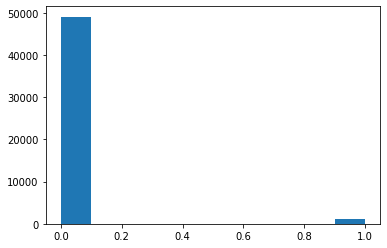

In [ ]:
#정상적으로 입력 됬는지 확인 
print(len(df[df['error']==1])/69)
temp = np.array(error)[:,2:]
print(len(temp[temp!=0]))
plt.hist(df['error'])
plt.show()

In [ ]:
np.array(df).shape

[]

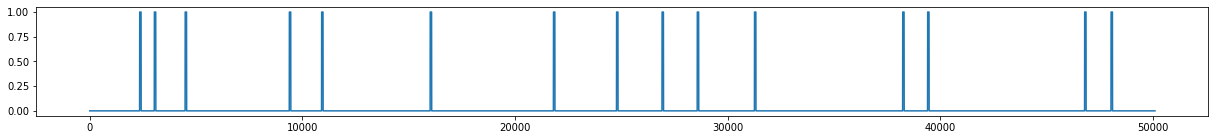

In [ ]:
plt.figure(figsize=(21,2))
plt.plot(np.arange(len(df)),df['error'])
plt.plot()

# 전처리

### 컬럼 제거 

In [ ]:
columns = ['pH','Temp','Current','error']

In [ ]:
df_1 = df[columns]

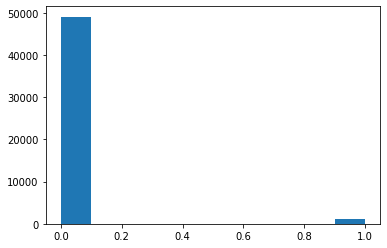

In [ ]:
plt.hist(df_1['error'])
plt.show()

### train - test 분리

In [ ]:
index = 550*69
train_df = df_1.iloc[:index]
test_df = df_1.iloc[index:]

### 0-1 분리

In [ ]:
train_normal = train_df[train_df['error']==0]
train_anormal = train_df[train_df['error']==1]

In [ ]:
print(np.array(train_normal).reshape(-1,69,4).shape)
print(np.array(train_anormal).reshape(-1,69,4).shape)

(539, 69, 4)
(11, 69, 4)


### output 데이터

In [ ]:
train_normal_output = np.zeros(539)
train_anormal_output = np.ones(11)

### Reshape

In [ ]:
train_normal = np.array(train_normal).reshape(-1,69,4)[:,:,:3]
train_anormal = np.array(train_anormal).reshape(-1,69,4)[:,:,:3]

In [ ]:
print(train_normal.shape)

(539, 69, 3)


### Min Max scaling 

In [ ]:
max = np.max(np.max(train_normal,axis=0),axis=0)
min = np.min(np.min(train_normal,axis=0),axis=0)

def scaling(df,max,min):
  scaled_df = (df-min)/(max-min)
  return scaled_df

In [ ]:
normal_input = scaling(train_normal,max,min)
anormal_input = scaling(train_anormal,max,min)

### Test Preprocessing

In [ ]:
test_df.head()

,pH,Temp,Current,error
0,10.38,43.01,7.31,0
1,9.98,42.84,7.99,0
2,10.34,45.75,7.78,0
3,10.60,45.45,7.06,0
4,10.76,42.95,8.20,0


Reshape

In [ ]:
test_input = np.array(test_df).reshape(-1,69,4)

In [ ]:
test_input.shape

(176, 69, 4)

In [ ]:
test_output = np.zeros(176)

for index in range(176):
  temp = test_input[index]
  if temp[:,3].sum()==69:
    test_output[index]=1

In [ ]:
test_input = test_input[:,:,:3]

In [ ]:
print(train_normal.shape,train_anormal.shape)
print(train_normal_output.shape,train_anormal_output.shape)
print('-----')
print(test_input.shape,test_output.shape)

(539, 69, 3) (11, 69, 3)
(539,) (11,)
-----
(176, 69, 3) (176,)


#모델

In [ ]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Bidirectional, LSTM, GRU

In [ ]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
# loss 실시간 출력 
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):
    self.epochs = []
    self.losses = []
    self.val_losses = []
    self.logs = []
    self.fig = plt.figure()


  def on_epoch_end(self, epoch, logs={}):

    self.epochs.append(epoch)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    clear_output(wait=True)
    plt.plot(self.epochs, self.losses, label="loss")
    plt.plot(self.epochs, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])

#call backs 선언
plot_losses = PlotLosses()

from tensorflow.keras.callbacks import ModelCheckpoint #<- model 저장 객체, best_model.h5라는 모델 이 저장 됨 
model_check_point = ModelCheckpoint(
    'best_model.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True)


from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링 대상, 이걸 기준으로 멈춤 
    verbose=1,
    patience=20)         # 중지까지의 여유분

from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', # 모니터링 대상
    patience=20,        # 대상ㅃ 기간동안 유지
    factor=0.2,         # 줄이는 양                              
    min_learning_rate=0.00001)     # 최소 학습율

callbacks = [model_check_point, plot_losses, reduce_lr]

In [ ]:
#Env 데이터 파트 
def model():
  input = Input((69,3)) #<---- shape 
  x = Bidirectional(LSTM(256,return_sequences= True))(input) #bidirec
  x = Bidirectional(LSTM(128))(x)
  x = Flatten()(x)
  x = BatchNormalization()(x)
  x = Dense(64, activation ='relu')(x)
  x = BatchNormalization()(x)
  x = Dense(32, activation ='relu')(x)
  x = BatchNormalization()(x)
  output = Dense(2,activation = 'softmax')(x)

  model = Model(input,output)
  model.compile(optimizer='adam', loss="sparse_categorical_crossentropy",metrics = ['accuracy'])
  return model

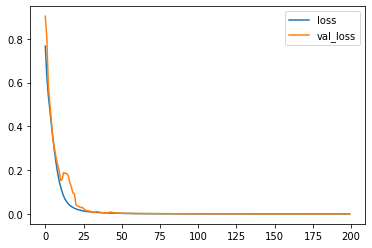

loss =  0.0003037884016521275 , val_loss =  0.0002963163424283266
16/16 [==============================] - 1s 34ms/step - loss: 3.0379e-04 - accuracy: 1.0000 - val_loss: 2.9632e-04 - val_accuracy: 1.0000 - lr: 8.0000e-06


In [ ]:
model = model()
model.fit(train_normal,train_normal_output, epochs=200, verbose=1, batch_size=32, validation_split=0.1,callbacks=callbacks)

# 예측

##Train의 normal 데이터 Max Softmax Score 분포 

In [ ]:
y_ = model.predict(train_normal)

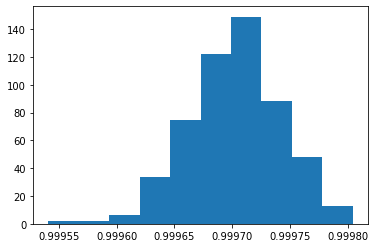

In [ ]:
plt.hist(np.max(y_,axis=1))
plt.show()

## Train의 anormal 데이터 Max Softmax Score 분포 

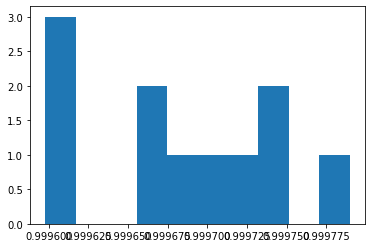

In [ ]:
y_ = model.predict(train_anormal)
plt.hist(np.max(y_,axis=1))
plt.show()

## Test 데이터 

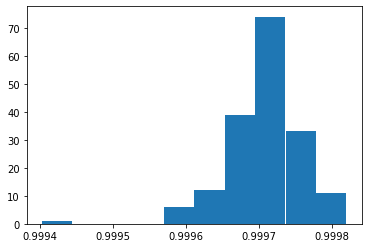

In [ ]:
y_ = model.predict(test_input)
predicted = np.max(y_,axis=1)
plt.hist(predicted)
plt.show()

In [ ]:
np.where(predicted <0.9995)

(array([129]),)

In [ ]:
test_output[129]

0.0

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_y, predicted)
print(cm)

[[172   0]
 [  4   0]]


In [ ]:
print(classification_report(test_y, predicted, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       172
           1       0.00      0.00      0.00         4

    accuracy                           0.98       176
   macro avg       0.49      0.50      0.49       176
weighted avg       0.96      0.98      0.97       176



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 준지도 학습 방법 

## 전처리

### train - test 분할

In [ ]:
train_x = input[:550]
train_y = output[:550]

test_x = input[550:]
test_y = output[550:]